# standard notebook for copying

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## get out lat and lon, tmask

In [4]:
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
print(np.shape(tmask))
print('SO south of -50 is 0:37, SO south of -30 is 0:50')
lats = tmesh['nav_lat'][:,0]
lons = tmesh['nav_lon'][0,:]

(149, 182)
SO south of -50 is 0:37, SO south of -30 is 0:50


### do a pcolormesh - this one looks wonky but syntax is fine

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


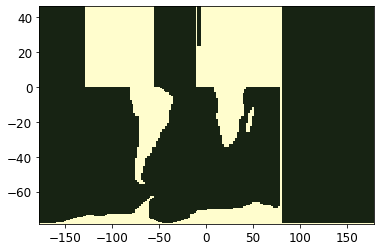

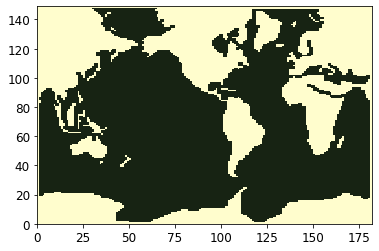

In [5]:
plt.figure()
plt.pcolormesh(lons, lats, tmask, vmin = 0, vmax = 1, cmap = cm.speed)

plt.figure()
plt.pcolormesh(tmask, vmin = 0, vmax = 1, cmap = cm.speed)

### get various tmesh things including volume_weighted means 

In [6]:
w2 = xr.open_dataset('//gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_19900101_19901231_ptrc_T.nc')

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

testDIC = w2.DIC.values[0,0,:,:] 

avgd_surface = np.ma.average(testDIC[:,:], weights = tmesh['csize'].values)
avgd_all = np.ma.average(w2.DIC.values[0,:,:,:], weights = cvol)
print(avgd_surface*1e6) 
print(avgd_all*1e6)

2048.457122967461
2334.5326478580837


## get means and percentiles with masks and nans

In [7]:
#get 2d array
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    data = np.ravel(data)
    weights = np.ravel(weights)
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

run = 'LIGD'
z = xr.open_dataset(f'/gpfs/home/e415/scratch/TOM10_CL_{run}/{run}_dia3d_1998_2010_ave.nc')
ppt_sam = (z['PPT'][0,0,:,:].values)

#get weights
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

#get weighted percentile
p95 = weighted_percentile(ppt_sam, tmesh['csize'], 0.95)
print(p95)

#get mean
ma = np.ma.MaskedArray(ppt_sam, mask=np.isnan(ppt_sam))
q = np.ma.average(ma, weights=tmesh['csize'])
print(q)

1.4918596958752192e-08
4.299022858926132e-09


## subplots

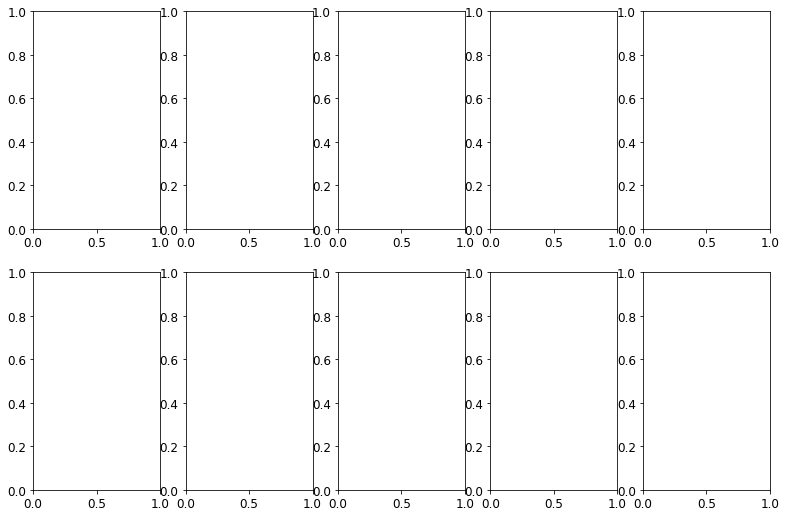

In [8]:

fact = 1.1
fig, axs = plt.subplots(2,5, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()




# make dataframe and save to .csv

In [ ]:

df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, tY_SO, tX_SO, tZ_SO, tZdep_SO, tDP_SO]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT', 'Y', 'X', 'Z', 'Zdep', 'DP']
df.wheremade = 'evalOutput/TA-DIC_GLODAP.ipynb and evalOutput/GLODAPv2021comparison_pipeline.ipynb'
df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_togrid.csv')

## latitude bands


In [9]:
bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
bounds = np.array([0,16,28,37,44,50])
starts = np.zeros([5]); ends = np.zeros([5])
print('making histograms of summer and winter wind speed for the following latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    bs = bounds[i]
    be = bounds[i+1]
    print(f'band {i}, {(s)} to {e}, index {bs} to {be}')
    starts[i] = s
    ends[i] = e
     
print(starts)
print(ends)

making histograms of summer and winter wind speed for the following latitude bands:
band 0, -78.2 to -69.5, index 0 to 16
band 1, -69.5 to -59.3, index 16 to 28
band 2, -59.3 to -48.8, index 28 to 37
band 3, -48.8 to -38.7, index 37 to 44
band 4, -38.7 to -28.7, index 44 to 50
[-78.2 -69.5 -59.3 -48.8 -38.7]
[-69.5 -59.3 -48.8 -38.7 -28.7]


## 

## custom histogram

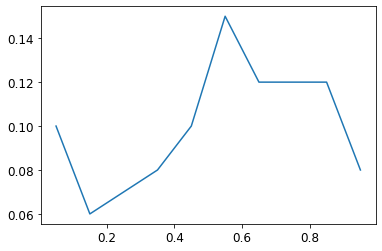

In [10]:
tdat = np.random.rand(100)
nbins = 10
start = 0
end = 1


def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback

nsback, bin_cent, histback = custhist(tdat, nbins, start, end)
plt.plot(bin_cent,histback)

## yearlists and open_mfdataset and horrible xarray selection that haunts me

In [11]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

yrst = 1972; yrend = 2020; tr = 'TOM12_TJ_1ASA'; dtype = 'ptrc_T'
baseDir = '/gpfs/data/greenocean/software/runs/'

ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
w = xr.open_mfdataset(ylist)

In [12]:

DIC_1AS1 = w.DIC

DIC_1AS1_mmn = DIC_1AS1.groupby('time_counter.month').mean('time_counter').values


In [13]:
DIC_1AS1.sel(time_counter=DIC_1AS1.time_counter.dt.month.isin([1, 2, 3, 10, 11, 12]))

<xarray.DataArray 'DIC' (time_counter: 294, deptht: 31, y: 149, x: 182)>
dask.array<getitem, shape=(294, 31, 149, 182), dtype=float32, chunksize=(6, 31, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * deptht         (deptht) float32 4.999938 15.000288 ... 4749.913 5250.2266
    time_centered  (time_counter) object dask.array<chunksize=(6,), meta=np.ndarray>
  * time_counter   (time_counter) object 1972-01-16 12:00:00 ... 2020-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           Dissolved inorganic Concentration
    units:               mol/L
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)

## make an xarray dataset

In [14]:
dic_obs = np.zeros([3,4,31])
alk_obs = np.zeros([3,4,31])
# define data with variable attributes
data_vars = {'dic':(['lat_band', 'season', 'z_index'], dic_obs,
                         {'units': 'µmol/L',
                          'long_name':'free-fall velocity'}),
             'ta':(['lat_band', 'season', 'z_index'], alk_obs,
                         {'units': 'µmol/L',
                          'long_name':'free-fall velocity'})            
            }

# define coordinates
coords = {'season': (['season'], np.arange(1,5,1)),\
         'lat_band': (['lat_band'], np.arange(0,3,1)),\
         'z_index': (['z_index'], np.arange(0,31,1))}

# define global attributes
attrs = {'made in':'evalOutput/TA-DIC_GLODAPOBS.ipynb',
         'latitude bands':'band 0, -78.2 to -69.5, index 0 to 16, band 1, -69.5 to -59.3, index 16 to 28 band 2, -59.3 to -48.8, index 28 to 37',
        'seasons': '1 is austral summer, 4 is spring'
        }
            
# create dataset
ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

fn = f'./examplenetcdf.nc'
ds.to_netcdf(fn)

## pandas

In [15]:
import pandas as pd

In [16]:
tdat = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_togrid.csv')
tdat.head()
tdat['DP']

0        2191.0
1        2191.0
2        2191.0
3        2191.0
4        2191.0
          ...  
54064    1282.0
54065    1282.0
54066    1282.0
54067    1282.0
54068    1690.0
Name: DP, Length: 54069, dtype: float64

### colours from colourmap

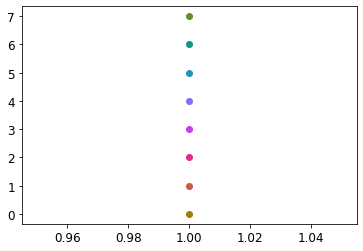

In [17]:
tcm = cm.phase
fig = plt.figure()

for i in range(0,8):
    plt.plot(1,i, marker = 'o', color = tcm(1.*(i)/8))

## get closest model point to a given lat and lon

In [18]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.
    Reference: http://www.movable-type.co.uk/scripts/latlong.html
    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`
    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`
    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`
    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`
    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_closest(lon1, lat1):
    w = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_20500101_20501231_ptrc_T.nc')
    lats = (w['nav_lat'][:])
    lons = w['nav_lon'][:]
    km = haversine(lon1, lat1, lons, lats)
    q = (np.where(km == np.min(km)))
    tY = q[0][0]
    tX = q[1][0]

    return tY, tX

lon1 = -20
lat1 = 20
print(f'test lon: {lon1}, test lat {lat1}')
tY, tX = find_closest(lon1, lat1)
print(f'returns x: {tX}, y {tY}')

test lon: -20, test lat 20
returns x: 131, y 91


find closest value in an array

In [19]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arval = array[idx]
    return(idx, arval)

array = np.arange(1,9,1)
value = 3.4
idx, arval = find_nearest(array, value)
print(array)
print(value)
print(idx)
print(arval)

[1 2 3 4 5 6 7 8]
3.4
2
3


# pickle

In [20]:
array = np.arange(1,9,1)
pickle.dump(array, open("examplepickle.pkl", 'wb'))
tpickle = pickle.load(open('./examplepickle.pkl', 'rb'))
print(tpickle)

[1 2 3 4 5 6 7 8]


## southern ocean plots

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


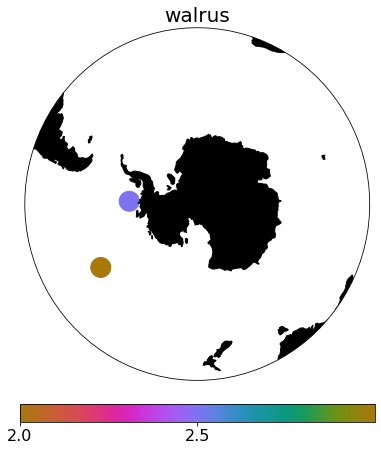

In [21]:
# from http://127.0.0.1:8888/lab/tree/prelimEvalForcing/CELOS-windclim.ipynb
def scatter_southern(fig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -30], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    #lons = nav_lon[0:37,:]; lats = nav_lat[0:37,:]; 
    mesh = ax1.scatter(lons, lats, s = dotsize, c = tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))
    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = fs)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=16)
    return cb

fact = 0.5
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax1 = tfig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, -90))
lons = np.array([-123, -88])
lats = np.array([-55, -70])
tdat = np.array([2, 2.5])
tvmin = 2
tvmax = 3
tticks = tdat
dotsize = 400
scatter_southern(fig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 20, 
                  tit = 'walrus', cbarlab = '', tcmap = cm.phase, lm = True, cbr = True)

## corinne masks

Text(0.5, 0.98, 'ocean regions, subdivided')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


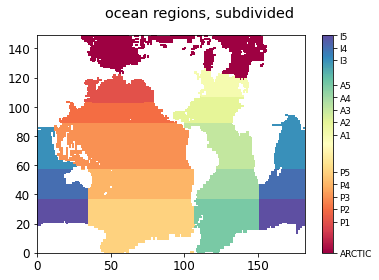

In [22]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')
